# IPM BEV transformation using Cam2Bev

**Assumption: World coordinates are in meter! (i.e., lane width is set to 6)**

In [98]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

class Camera:
  K = np.zeros([3, 3])
  R = np.zeros([3, 3])
  t = np.zeros([3, 1])
  P = np.zeros([3, 4])

  def setK(self, fx, fy, px, py):
    self.K[0, 0] = fx
    self.K[1, 1] = fy
    self.K[0, 2] = px
    self.K[1, 2] = py
    self.K[2, 2] = 1.0

  def setR(self, y, p, r):

    Rz = np.array([[np.cos(-y), -np.sin(-y), 0.0], [np.sin(-y), np.cos(-y), 0.0], [0.0, 0.0, 1.0]])
    Ry = np.array([[np.cos(-p), 0.0, np.sin(-p)], [0.0, 1.0, 0.0], [-np.sin(-p), 0.0, np.cos(-p)]])
    Rx = np.array([[1.0, 0.0, 0.0], [0.0, np.cos(-r), -np.sin(-r)], [0.0, np.sin(-r), np.cos(-r)]])
    Rs = np.array([[0.0, -1.0, 0.0], [0.0, 0.0, -1.0], [1.0, 0.0, 0.0]]) # switch axes (x = -y, y = -z, z = x)
    self.R = Rs.dot(Rz.dot(Ry.dot(Rx)))

  def setT(self, XCam, YCam, ZCam):
    X = np.array([XCam, YCam, ZCam])
    self.t = -self.R.dot(X)

  def updateP(self):
    Rt = np.zeros([3, 4])
    Rt[0:3, 0:3] = self.R
    Rt[0:3, 3] = self.t
    self.P = self.K.dot(Rt)

  def __init__(self, config):
    self.config = config
    self.setK(config["fx"], config["fy"], config["px"], config["py"])
    self.setR(np.deg2rad(config["yaw"]), np.deg2rad(config["pitch"]), np.deg2rad(config["roll"]))
    self.setT(config["XCam"], config["YCam"], config["ZCam"])
    self.updateP()

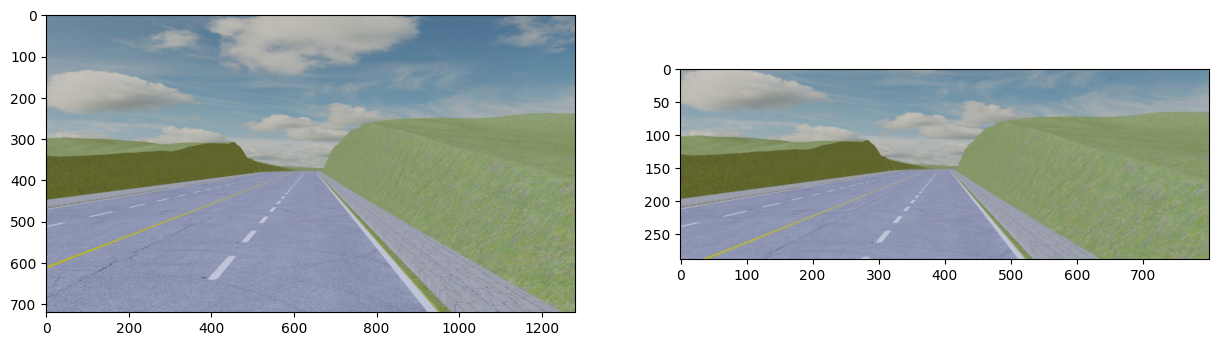

In [99]:

# DEFAULT_SENSOR_OFFSET = (0., 0.8, 1.5)

config_1280x720 = {
    'fx': 1108.5125168440816, 
    'fy': 1108.512494908983, 
    'px': 640.0, 
    'py': 360.0, 
    'yaw': 90.0, 
    'pitch': 0.0, 
    'roll': 0.0, 
    'XCam': 0.0, 
    'YCam': 0.0, 
    'ZCam': 1.5
}
cam_big = Camera(config_1280x720)
image_big = np.array(cv2.cvtColor(cv2.imread("basic_1280_720.jpg"), cv2.COLOR_BGR2RGB))

config_800x288 = {
    'fx': 692.820323027551, 
    'fy': 692.8203580762425, 
    'px': 400.0, 
    'py': 144.0, 
    'yaw': 90.0, 
    'pitch': 0.0, 
    'roll': 0.0, 
    'XCam': 0.0, 
    'YCam': 0.0, 
    'ZCam': 1.5
}
cam_small = Camera(config_800x288)
image_small = np.array(cv2.cvtColor(cv2.imread("basic_800_288.jpg"), cv2.COLOR_BGR2RGB))

# plot both iamges with matplotlib
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(image_big)
ax[1].imshow(image_small)


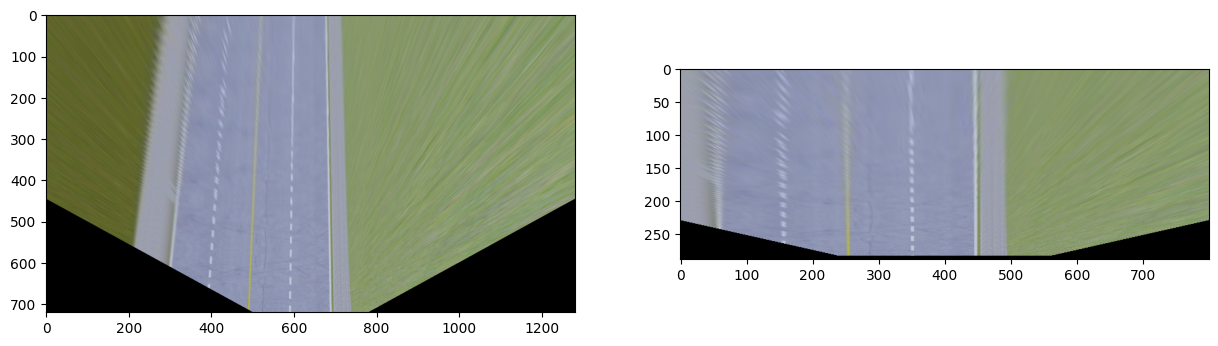

In [110]:

def get_ipm_matrix(cam, image):
    height, width, _ = image.shape

    cam_height = 50.0
    x_offset = 35.0 # in driving direction

    outputRes = (int(2 * cam.config["py"]), int(2 * cam.config["px"]))
    dx = outputRes[1] / cam.config["fx"] * cam_height
    dy = outputRes[0] / cam.config["fy"] * cam_height
    pxPerM = (outputRes[0] / dx, outputRes[1] / dy)


    # setup mapping from street/top-image plane to world coords
    shift = (outputRes[0] / 2.0, outputRes[1] / 2.0) # was (outputRes[0] / 2.0, outputRes[1] / 2.0)
    shift = shift[0] + x_offset * pxPerM[0], shift[1] - cam.config["XCam"] * pxPerM[1]
    M = np.array([[1.0 / pxPerM[1], 0.0, -shift[1] / pxPerM[1]], [0.0, -1.0 / pxPerM[0], shift[0] / pxPerM[0]], [0.0, 0.0, 0.0], [0.0, 0.0, 1.0]])

    ipm = np.linalg.inv(cam.P.dot(M))
    return ipm

ipm_big = get_ipm_matrix(cam_big, image_big)
ipm_small = get_ipm_matrix(cam_small, image_small)

# warp the images
warped_big = cv2.warpPerspective(image_big, ipm_big, (image_big.shape[1], image_big.shape[0]))
warped_small = cv2.warpPerspective(image_small, ipm_small, (image_small.shape[1], image_small.shape[0]))

# plot the warped images
fig, ax = plt.subplots(1, 2, figsize=(15, 8))
ax[0].imshow(warped_big)
ax[1].imshow(warped_small)